In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import io


from skforecast.model_selection import grid_search_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom

from sklearn.ensemble import RandomForestClassifier
#Filter warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# Download the csv file prepared by Apache spark from the githib repository
url='https://raw.githubusercontent.com/raku43/MSCS2/main/Clean_Tweet_Ca2.csv'
download=requests.get(url).content
#download

In [3]:
#Read the csv file with utf-8 decoding
df = pd.read_csv(io.StringIO(download.decode('utf-8')))
df.head()

,Unnamed: 0,tweetid,Date,Year,Month,Day,Tweet,sentiment
0,0,1282939902531790000,14/07/2020,2020.0,7.0,Tuesday,Cute,1
1,1,1282844872571900000,14/07/2020,2020.0,7.0,Tuesday,Wow,1
2,2,1282805559834490000,13/07/2020,2020.0,7.0,Monday,Reusability essential rocket single use absurd...,0
3,3,1282800187308570000,13/07/2020,2020.0,7.0,Monday,Wild times,2
4,4,1282800078000800000,13/07/2020,2020.0,7.0,Monday,We’re extra paranoid Maximizing probability su...,1


In [204]:
df=df[['tweetid','Date','Year','Month','Day','Tweet','sentiment']]

In [205]:
df.head()

,tweetid,Date,Year,Month,Day,Tweet,sentiment
0,1282939902531790000,14/07/2020,2020.0,7.0,Tuesday,Cute,1
1,1282844872571900000,14/07/2020,2020.0,7.0,Tuesday,Wow,1
2,1282805559834490000,13/07/2020,2020.0,7.0,Monday,Reusability essential rocket single use absurd...,0
3,1282800187308570000,13/07/2020,2020.0,7.0,Monday,Wild times,2
4,1282800078000800000,13/07/2020,2020.0,7.0,Monday,We’re extra paranoid Maximizing probability su...,1


In [206]:
df['sentiment'].describe()

count    9201.000000
mean        1.259537
std         0.666939
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: sentiment, dtype: float64

In [207]:
a = df.Tweet.to_string() #loads the row from dataframe
#print(a)

In [208]:
#Remove Emojis
import re
regex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
match = re.sub(regex_pattern,'',a) #replaces pattern with ''
#print(match)

In [209]:
re_list = ['@[A-Za-z0–9_]+', '#']
combined_re = re.compile( '|'.join( re_list) )
match = re.sub(combined_re,'',a)

In [210]:
from bs4 import BeautifulSoup
del_amp = BeautifulSoup(a, 'lxml')
del_amp_text = del_amp.get_text()


In [211]:
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
token = WordPunctTokenizer()
def cleaning_tweets(t):
    del_amp = BeautifulSoup(t, 'lxml')
    del_amp_text = del_amp.get_text()
    del_link_mentions = re.sub(combined_re, '', del_amp_text)
    del_emoticons = re.sub(regex_pattern, '', del_link_mentions)
    lower_case = del_emoticons.lower()
    words = token.tokenize(lower_case)
    result_words = [x for x in words if len(x) > 2]
    return (" ".join(result_words)).strip()

In [212]:
print("Cleaning the tweets...\n")
cleaned_tweets = []
for i in range(0,24): #3000 columns in our dataframe
    if( (i+1)%100 == 0 ):
        print("Tweets {} of {} have ben processed".format(i+1,24))                                                                  
    cleaned_tweets.append(cleaning_tweets((df.Tweet[i])))


Cleaning the tweets...



In [213]:
string = pd.Series(cleaned_tweets).str.cat(sep=' ')


In [214]:
#wordcloud = WordCloud(width=1600, stopwords=stopwords,height=800,max_font_size=200,max_words=2,collocations=False, background_color='black').generate(string)
#plt.figure(figsize=(40,30))
#plt.imshow(wordcloud, interpolation="bilinear")
#plt.axis("off")
#plt.show()

In [215]:
df.groupby(['sentiment'])['Tweet'].agg('count')

sentiment
0    1162
1    4489
2    3550
Name: Tweet, dtype: int64

1 -> Positive tweets
0 -> Negative Tweets
2 -> Neutral


In [216]:
dfaggt=df.groupby(['sentiment','Day'])['Tweet'].agg(["count"]).sort_values(by='count',ascending=True)
dfaggt['count']

sentiment  Day      
0          Wednesday    132
           Tuesday      141
           Monday       153
           Sunday       178
           Thursday     180
           Saturday     182
           Friday       196
2          Tuesday      438
           Monday       453
           Wednesday    473
           Saturday     509
           Sunday       520
           Thursday     537
1          Wednesday    563
           Tuesday      571
           Monday       581
2          Friday       620
1          Thursday     672
           Saturday     687
           Sunday       697
           Friday       718
Name: count, dtype: int64

In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9201 entries, 0 to 9378
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweetid    9201 non-null   object 
 1   Date       9201 non-null   object 
 2   Year       9201 non-null   float64
 3   Month      9201 non-null   float64
 4   Day        9201 non-null   object 
 5   Tweet      9201 non-null   object 
 6   sentiment  9201 non-null   int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 833.1+ KB


In [218]:
import seaborn as sns

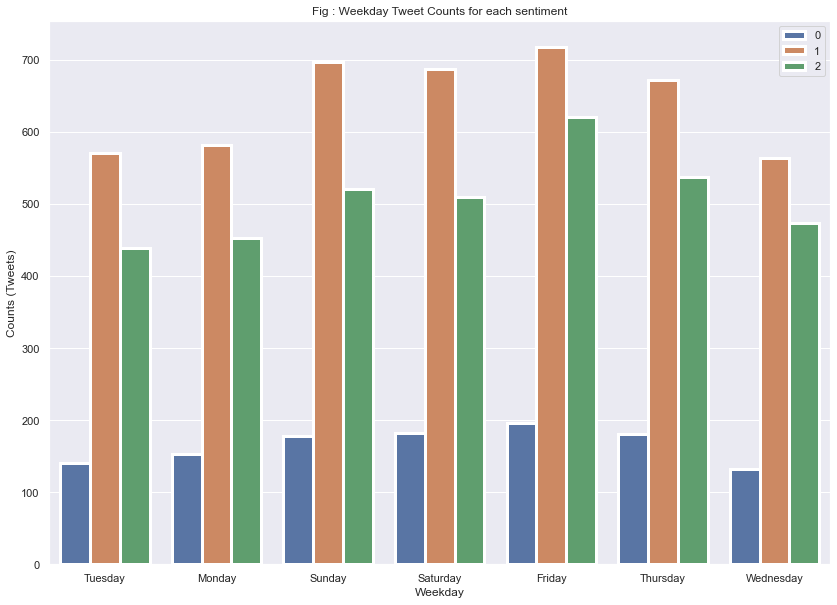

In [219]:
#Plot showing Weekly tweets based on sentiments

sns.set_style('darkgrid') #usage of seaborn library set the style
sns.set(rc={'figure.figsize':(14,10)}) #usage of seaborn library set the figure size
sns.color_palette("tab10")#usage of seaborn library set the color palette
ax = sns.countplot(data=df, x ='Day',
                  hue='sentiment', lw=3) # Draw the plot

plt.legend(bbox_to_anchor=(1, 1)) # Set the legends 
plt.ylabel('Counts (Tweets)') # Y label
plt.xlabel('Weekday') # X label
plt.title('Fig : Weekday Tweet Counts for each sentiment') # Set the title
plt.show() # Display the plot

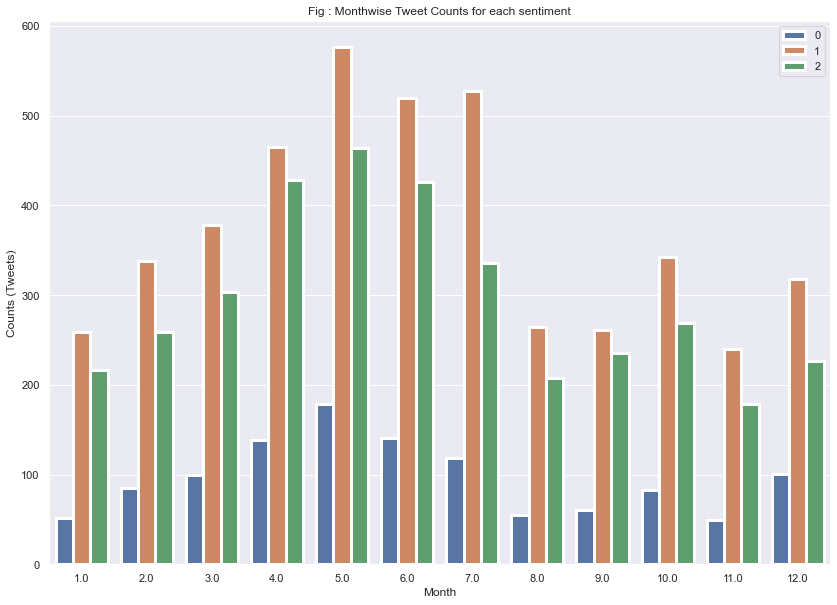

In [220]:
#Plot showing Weekly tweets based on sentiments

sns.set_style('darkgrid') #usage of seaborn library set the style
sns.set(rc={'figure.figsize':(14,10)}) #usage of seaborn library set the figure size
sns.color_palette("tab10")#usage of seaborn library set the color palette
ax = sns.countplot(data=df, x ='Month',
                  hue='sentiment', lw=3) # Draw the plot

plt.legend(bbox_to_anchor=(1, 1)) # Set the legends 
plt.ylabel('Counts (Tweets)') # Y label
plt.xlabel('Month') # X label
plt.title('Fig : Monthwise Tweet Counts for each sentiment') # Set the title
plt.show() # Display the plot

<AxesSubplot:xlabel='sentiment', ylabel='count'>

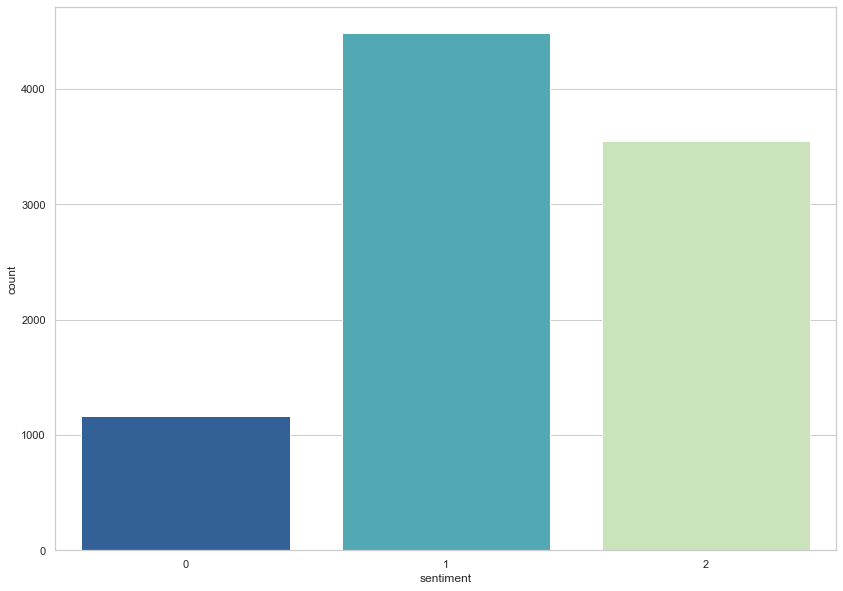

In [221]:
sns.set_style('whitegrid')
sns.countplot(x='sentiment',data=df, palette='YlGnBu_r')

In [222]:
df['sentiment_text'] = df['sentiment'].apply(lambda x: 'Positive' if x ==1 else('Neutral' if x == 2  else 'Negative'))

In [223]:
df.head()

,tweetid,Date,Year,Month,Day,Tweet,sentiment,sentiment_text
0,1282939902531790000,14/07/2020,2020.0,7.0,Tuesday,Cute,1,Positive
1,1282844872571900000,14/07/2020,2020.0,7.0,Tuesday,Wow,1,Positive
2,1282805559834490000,13/07/2020,2020.0,7.0,Monday,Reusability essential rocket single use absurd...,0,Negative
3,1282800187308570000,13/07/2020,2020.0,7.0,Monday,Wild times,2,Neutral
4,1282800078000800000,13/07/2020,2020.0,7.0,Monday,We’re extra paranoid Maximizing probability su...,1,Positive


# Bag of Words using Count vectorizer

In [224]:
nan_rows = df[df['Tweet'].isnull()]
nan_rows

,tweetid,Date,Year,Month,Day,Tweet,sentiment,sentiment_text


In [225]:
df = df.dropna()

In [226]:
nan_rows = df[df['Tweet'].isnull()]
nan_rows

,tweetid,Date,Year,Month,Day,Tweet,sentiment,sentiment_text


In [251]:
#Apply Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate an object cv by calling a method named as CountVectorzer()
cv    = CountVectorizer(max_features = 3000, stop_words = ['tesla', 'unit','car','space'])

# Train the dataset by calling a fit_transform() method
X_fin = cv.fit_transform(df['Tweet']).toarray()

# Display the rows and colums
X_fin.shape

(9201, 3000)

In [252]:
from sklearn.model_selection import train_test_split

X = df['Tweet'].values
y = df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X_fin, y, test_size=0.30, random_state=42)


In [254]:
X_train.shape

(6440, 3000)

In [255]:
y_test.shape

(2761,)

In [256]:
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train = X_train.toarray()
X_test = X_test.toarray()

In [257]:
#Let us analyse sentiment using Multinomial NB
#from sklearn.naive_bayes import MultinomialNB


In [258]:
#Let us analyse sentiment using Multinomial NB
from sklearn.naive_bayes import MultinomialNB
# Instantiate an object model by calling a method MultinomialNB()
model = MultinomialNB()

In [259]:
# Train the model by calling a method fit()
model.fit(X_train,y_train)

MultinomialNB()

In [260]:
# Call predict() method
y_pred = model.predict(X_test)
y_pred2= model.predict(X_train)

In [261]:
from sklearn.metrics import classification_report

# Instantiate a mthod named as Cla
cf1 = classification_report(y_train, y_pred2)
cf2 = classification_report(y_test, y_pred)

# Display the values of an object cf
print("Train Scores: "+cf1)
print("Test Scores: "+cf2)

Train Scores:               precision    recall  f1-score   support

           0       0.99      0.28      0.44       854
           1       0.73      0.96      0.83      3126
           2       0.84      0.72      0.78      2460

    accuracy                           0.78      6440
   macro avg       0.85      0.65      0.68      6440
weighted avg       0.81      0.78      0.76      6440

Test Scores:               precision    recall  f1-score   support

           0       0.88      0.15      0.26       308
           1       0.66      0.90      0.76      1363
           2       0.75      0.58      0.65      1090

    accuracy                           0.69      2761
   macro avg       0.76      0.54      0.56      2761
weighted avg       0.72      0.69      0.66      2761



In [187]:
#Import Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Set the number of features we want
number_of_features = 3000

#Import Sequential Model from Keras
model = Sequential()

# Add Layers, we will use three hidden layers and an output layer
model.add(Dense(units=1000,activation='relu',input_shape = (number_of_features,)))

model.add(Dense(units=500,activation='relu'))

model.add(Dense(units=500,activation='relu'))

model.add(Dense(units=1, activation='softmax'))

# Use of optimizers
opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

#Early stop to stop epochs
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [188]:
X_fin.shape

(9201, 3000)

In [189]:
output = []
for x in y_train:
    if x not in output:
        output.append(x)
print(output)

[2, 1, 0]


In [192]:
model = Sequential()

model.add(Dense(units=12673,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=4000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=500,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1, activation='softmax'))

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

#early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [193]:
model.fit(x=X_train, y=y_train, batch_size=256, epochs=100, validation_data=(X_test, y_test), verbose=1,callbacks=early_stop)

Epoch 1/100
26/26 [==============================] - 37s 1s/step - loss: 0.0000e+00 - accuracy: 0.4854 - val_loss: 0.0000e+00 - val_accuracy: 0.4937
Epoch 2/100
26/26 [==============================] - 33s 1s/step - loss: 0.0000e+00 - accuracy: 0.4854 - val_loss: 0.0000e+00 - val_accuracy: 0.4937
Epoch 3/100
26/26 [==============================] - 31s 1s/step - loss: 0.0000e+00 - accuracy: 0.4854 - val_loss: 0.0000e+00 - val_accuracy: 0.4937
Epoch 3: early stopping


In [ ]:
model.fit(x=X_train, y=y_train, batch_size=256, epochs=100, validation_data=(X_test, y_test), verbose=1, callbacks=early_stop)

In [157]:
#Evaluate the Model
model_score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
#print('Test accuracy:', model_score[1])

44/44 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.4937


In [161]:
preds = model.predict(X_test)
preds

87/87 [==============================] - 1s 8ms/step


array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [162]:
output = []
for x in preds:
    if x not in output:
        output.append(x)
print(output)

[array([1.], dtype=float32)]


In [148]:
scores = model.evaluate(X_train, y_train)
print("Training Accuracy: %.2f%%\n" % (scores[1] * 100))

scores = model.evaluate(X_test, y_test)
print("Testing Accuracy: %.2f%%\n" % (scores[1] * 100))

202/202 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.4854
Training Accuracy: 48.54%

87/87 [==============================] - 1s 9ms/step - loss: 0.0000e+00 - accuracy: 0.4937
Testing Accuracy: 49.37%



Very less accuracy aroubd 49% let us apply hyperparameter  and see if we can improve the scores

# Hyperparameter Tuning

In [195]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
from sklearn.svm import SVC

stop = stopwords.words('english')

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None]
              },
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
              'vect__use_idf':[False],
               'vect__norm':[None]
              },
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     (('svc', SVC()))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

In [37]:
X_fin

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [38]:
from sklearn.model_selection import train_test_split
df['sentiment_text'] = df['sentiment'].apply(lambda x: 'Positive' if x ==1 else('Neutral' if x == 2  else 'Negative'))
X = df['Tweet'].values
y = df['sentiment_text'].values
X_trainhp, X_testhp, y_trainhp, y_testhp = train_test_split(X, y, test_size=0.30, random_state=42)


In [39]:
gs_lr_tfidf.fit(X_trainhp, y_trainhp)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid=[{'vect__ngram_range': [(1, 1)],
                          'vect__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
                                                'yourselves', 'he', 'him',
                                                'his', 'himself', 'she',
                                                "she's", 'h...
                         {'vect__ngram_range': [(1, 1)], 'vect__norm': [None],
                          'vect__stop_words': [['i', '

In [41]:
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)
clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_testhp, y_testhp))

Best parameter set: {'vect__ngram_range': (1, 1), 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'som

# Booster Algorithm

In [43]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [44]:
X = df['Tweet'].values
y = df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X_fin, y, test_size=0.30, random_state=42)


In [45]:
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          verbose=20)

[20]	training's multi_logloss: 0.589398	valid_0's multi_logloss: 0.598815
[40]	training's multi_logloss: 0.512202	valid_0's multi_logloss: 0.550008
[60]	training's multi_logloss: 0.476293	valid_0's multi_logloss: 0.540309
[80]	training's multi_logloss: 0.45293	valid_0's multi_logloss: 0.541881
[100]	training's multi_logloss: 0.435169	valid_0's multi_logloss: 0.545207


LGBMClassifier(random_state=42)

In [46]:
print('Training accuracy {:.4f}'.format(model.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test,y_test)))

Training accuracy 0.8526
Testing accuracy 0.8015


# Applying one hot encoding to see if the performance improves

In [47]:
one_hot = pd.get_dummies(df["sentiment_text"])
df.drop(['sentiment_text'],axis=1,inplace=True)
df = pd.concat([df,one_hot],axis=1)
df.head()

,tweetid,Date,Year,Month,Day,Tweet,sentiment,Negative,Neutral,Positive
0,1282939902531790000,14/07/2020,2020.0,7.0,Tuesday,Cute,1,0,0,1
1,1282844872571900000,14/07/2020,2020.0,7.0,Tuesday,Wow,1,0,0,1
2,1282805559834490000,13/07/2020,2020.0,7.0,Monday,Reusability essential rocket single use absurd...,0,1,0,0
3,1282800187308570000,13/07/2020,2020.0,7.0,Monday,Wild times,2,0,1,0
4,1282800078000800000,13/07/2020,2020.0,7.0,Monday,We’re extra paranoid Maximizing probability su...,1,0,0,1


In [48]:
y=df[['Negative','Neutral','Positive']]

In [49]:
y.shape

(9201, 3)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_fin, y, test_size=0.30, random_state=42)

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()

model.add(Dense(units=1000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=500,activation='relu'))
model.add(Dropout(0.5))

#model.add(Dense(units=500,activation='relu'))
#model.add(Dropout(0.5))

model.add(Dense(units=3, activation='softmax'))

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [68]:
y_train.shape

(6440, 3)

In [69]:
history=model.fit(x=X_train, y=y_train, batch_size=200, epochs=10, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
33/33 [==============================] - 2s 44ms/step - loss: 0.9131 - accuracy: 0.5953 - val_loss: 0.6537 - val_accuracy: 0.7776
Epoch 2/10
33/33 [==============================] - 1s 39ms/step - loss: 0.4354 - accuracy: 0.8469 - val_loss: 0.4508 - val_accuracy: 0.8392
Epoch 3/10
33/33 [==============================] - 1s 40ms/step - loss: 0.1747 - accuracy: 0.9469 - val_loss: 0.5108 - val_accuracy: 0.8424
Epoch 4/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0911 - accuracy: 0.9780 - val_loss: 0.5125 - val_accuracy: 0.8504
Epoch 5/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0551 - accuracy: 0.9876 - val_loss: 0.5699 - val_accuracy: 0.8493
Epoch 6/10
33/33 [==============================] - 1s 39ms/step - loss: 0.0445 - accuracy: 0.9898 - val_loss: 0.6198 - val_accuracy: 0.8486
Epoch 7/10
33/33 [==============================] - 1s 40ms/step - loss: 0.0361 - accuracy: 0.9921 - val_loss: 0.6656 - val_accuracy: 0.8435
Epoch 8/10
33

In [70]:
preds = model.predict(X_test)
preds

87/87 [==============================] - 1s 6ms/step


array([[9.9761009e-01, 1.9327879e-07, 2.3896494e-03],
       [1.0849488e-02, 9.7763455e-01, 1.1516033e-02],
       [2.0823109e-06, 9.0812037e-12, 9.9999797e-01],
       ...,
       [3.1747273e-08, 3.6248532e-10, 1.0000000e+00],
       [9.9821401e-01, 1.7466467e-04, 1.6113544e-03],
       [6.1733806e-01, 4.4722434e-02, 3.3793950e-01]], dtype=float32)

In [71]:
y_train_pred= model.predict(X_train)

202/202 [==============================] - 1s 5ms/step


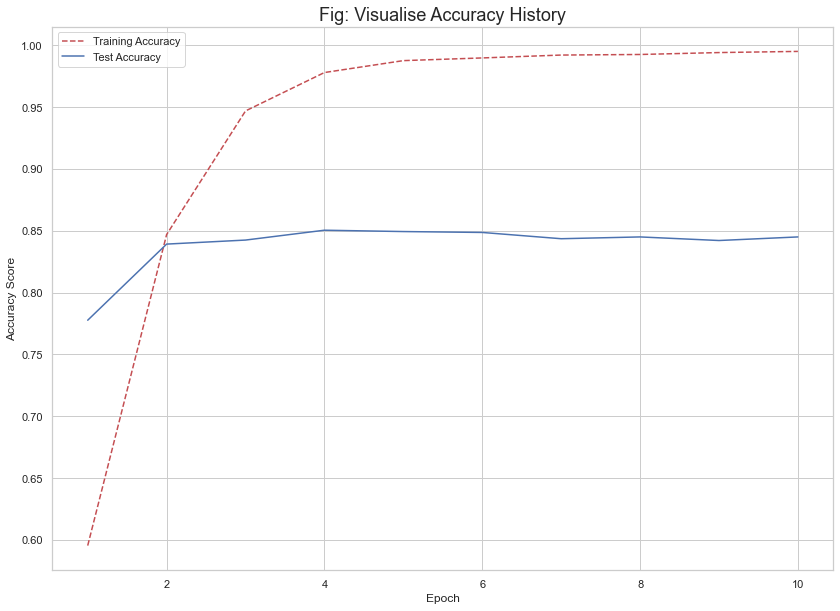

Accuracy :  [0.5953416228294373, 0.846894383430481, 0.9468944072723389, 0.9779503345489502, 0.9875776171684265, 0.9897515773773193, 0.9920807480812073, 0.992546558380127, 0.9940993785858154, 0.9950310587882996] [0.7776167988777161, 0.8391886949539185, 0.8424484133720398, 0.8504165410995483, 0.849329948425293, 0.8486055731773376, 0.8435349464416504, 0.844983696937561, 0.8420861959457397, 0.844983696937561]
R2 :  0.9851469344756896 0.49997818001297195


In [72]:
from sklearn.metrics import r2_score

# Get training and test loss histories
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Get training and test accuracy histories
an_training_accuracy = history.history["accuracy"]
an_test_accuracy = history.history["val_accuracy"]

R2_AN_train=r2_score(y_train, y_train_pred)
R2_AN_test=r2_score(y_test,preds)

plt.plot(epoch_count, an_training_accuracy, "r--")
plt.plot(epoch_count, an_test_accuracy, "b-")

# Visualize accuracy history
plt.legend(["Training Accuracy", "Test Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")
plt.title("Fig: Visualise Accuracy History",fontsize=18)

plt.show();

print('Accuracy : ',an_training_accuracy,an_test_accuracy)
print('R2 : ',R2_AN_train,R2_AN_test)

In [73]:
scores = model.evaluate(X_train, y_train)
print("Training Accuracy: %.2f%%\n" % (scores[1] * 100))

scores = model.evaluate(X_test, y_test)
print("Testing Accuracy: %.2f%%\n" % (scores[1] * 100))

202/202 [==============================] - 1s 6ms/step - loss: 0.0210 - accuracy: 0.9952
Training Accuracy: 99.52%

87/87 [==============================] - 1s 7ms/step - loss: 0.7619 - accuracy: 0.8450
Testing Accuracy: 84.50%



# Time Series Forecasting

In [ ]:
#Changethe Date field to pandas datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [ ]:
#Group by date and randomly take only one tweet per day
df_timeseries=df.groupby('Date').apply(lambda x: x.sample(1)).reset_index(drop=True).sort_values(by='Date')

In [ ]:
df_timeseries.info()

In [ ]:
df_timeseries.head(20)

In [ ]:
df_timeseries=df_timeseries[['Date','sentiment']]


In [ ]:
df_timeseries = df_timeseries.set_index('Date')
df_timeseries.head(20)

In [ ]:
df_timeseries_daily = df_timeseries.asfreq('D','ffill')
df_timeseries_daily = df_timeseries_daily.sort_index()
df_timeseries_daily.head(20)

In [ ]:
# Time series data source: elonmusk tweets.
import matplotlib.pyplot as plt

# Draw Plot
def plot_df(df_timeseries_daily, x, y, title="", xlabel='Date', ylabel='sentiment', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df_timeseries_daily, x=df_timeseries_daily.index, y=df_timeseries_daily.sentiment, title='Daily tweet sentiment of Elon Musk') 

In [ ]:
!pip install wordcloud

In [ ]:
print(f'Number of rows with missing values: {df.isnull().any(axis=1).mean()}')

In [ ]:
# we will clean up the NaN with the ffill and bfill function. ffill will fill the NA fields based on the value in previous row for the column, if the first field itself is not available it will fill then next fill using bfill

#f_timeseries_daily=df_timeseries['sentiment'].ffill()



In [ ]:
df_timeseries_weekly = df_timeseries.asfreq('W','ffill')
df_timeseries_weekly = df_timeseries_weekly.sort_index()
df_timeseries_weekly.head(20)

In [ ]:
df_timeseries_weeklydi=df_timeseries_weekly.reset_index()
df_timeseries_weeklydi=df_timeseries_weeklydi.loc[df_timeseries_weeklydi['Date']>='2019-01-01']

In [ ]:
# Time series data source: elonmusk tweets.
import matplotlib.pyplot as plt
df=df_timeseries_weekly

#dflsraw.loc[dflsraw['YEAR']<2021]
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='sentiment', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.sentiment, title='Weekly tweet sentiment of Elon Musk') 

In [ ]:
df_timeseries_monthly = df_timeseries.asfreq('M','ffill')
df_timeseries_monthly = df_timeseries_monthly.sort_index()
df_timeseries_monthly.head(20)

In [ ]:
df_timeseries_quarterly = df_timeseries.asfreq('Q','ffill')
df_timeseries_quarterly = df_timeseries_quarterly.sort_index()
df_timeseries_quarterly.head(20)

In [ ]:
sns.set()
plt.ylabel('Sentiment')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(df_timeseries_monthly.index, df_timeseries_monthly['sentiment'] )
plt.show()

In [ ]:
train = df_timeseries_monthly[df_timeseries_monthly.index < pd.to_datetime("2019-01-01", format='%Y-%m-%d')]
test = df_timeseries_monthly[df_timeseries_monthly.index >= pd.to_datetime("2019-01-01", format='%Y-%m-%d')]
test

In [ ]:
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('Sentiment')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Sentiment")
plt.show()

In [ ]:
# Use Min Max Scaler for standardising the data
#from sklearn.preprocessing import  MinMaxScaler
#sc= MinMaxScaler()
##X= sc.fit_transform(X)
#y=df_timeseries_weekly['sentiment'].values
#y= y.reshape(-1,1)
#y=sc.fit_transform(y)
#df_scaler=pd.DataFrame(y)
#df_scaler

In [ ]:
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX
y = train['sentiment']

#ARIMA model
# contrived dataset 
data =df_timeseries_weekly
# fit model 
modela = ARIMA(y, order=(1,2,0)) 
modela_fit = modela.fit() 
# make prediction 
yhat = modela_fit.predict(len(data), len(data)) 
print(yhat)

In [ ]:
#ARMA model
y = train['sentiment']

ARMAmodel = SARIMAX(y, order = (1, 0, 2))
ARMAmodel = ARMAmodel.fit()

y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], 
                                             end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_outARMA = y_pred_df["Predictions"] 

plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('sentiment')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train test and Predictions for Tweet Sentiments")
plt.plot(y_pred_outARMA, color='green', label = 'ARMA Predictions')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test["sentiment"].values, y_pred_df["Predictions"]))
print("ARMA RMSE: ",arma_rmse)

In [ ]:

ARIMAmodel = SARIMAX(y, order = (5, 4, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0],
                                              end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_outARIMA = y_pred_df["Predictions"]

In [ ]:
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('Sentiments')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Comparing different traditional timeseries forecasting models")
plt.plot(y_pred_outARMA, color='Blue', label = 'ARMA Predictions')
plt.plot(y_pred_outARIMA, color='Yellow', label = 'ARIMA Predictions')
plt.legend()
plt.show()

In [ ]:
def timeseries_pred(x):
    data=x
    train = data[data.index < pd.to_datetime("2019-01-01", format='%Y-%m-%d')]
    test = data[data.index >= pd.to_datetime("2019-01-01", format='%Y-%m-%d')]
    #ARMA model
    y = train['sentiment']

    ARMAmodel = SARIMAX(y, order = (1, 0, 2))
    ARMAmodel = ARMAmodel.fit()

    y_pred = ARMAmodel.get_forecast(len(test.index))
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], 
                                             end = y_pred_df.index[-1])
    y_pred_df.index = test.index
    y_pred_outARMA = y_pred_df["Predictions"] 

    plt.plot(train, color = "black", label = 'Training')
    plt.plot(test, color = "red", label = 'Testing')
    plt.ylabel('sentiment')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.title("Train ,test and Predictions(ARMA) for Tweet Sentiments")
    plt.plot(y_pred_outARMA, color='green', label = 'ARMA Predictions')
    plt.legend()
    plt.show()
    arma_rmse = np.sqrt(mean_squared_error(test["sentiment"].values, y_pred_df["Predictions"]))
    print("ARMA RMSE: ",arma_rmse)
    

In [ ]:
monthlypred_arma=timeseries_pred(df_timeseries_monthly)

In [ ]:
weeklypred_arma=timeseries_pred(df_timeseries_weekly)

In [ ]:
weeklypred_arma=timeseries_pred(df_timeseries_quarterly)

In [ ]:
print(f'Number of rows with missing values: {df_timeseries_daily.isnull().any(axis=1).mean()}')

In [ ]:
train = df_timeseries_monthly[df_timeseries_monthly.index <= pd.to_datetime("2018-12-31", format='%Y-%m-%d')]
test = df_timeseries_monthly[df_timeseries_monthly.index >= pd.to_datetime("2019-01-01", format='%Y-%m-%d')]
test

In [ ]:
print(f"Train dates : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates  : {test.index.min()} --- {test.index.max()}  (n={len(test)})")


In [ ]:
print(f"Train dates : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates  : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

fig, ax=plt.subplots(figsize=(9, 4))
train['sentiment'].plot(ax=ax, label='train')
test['sentiment'].plot(ax=ax, label='test')
ax.legend();

In [ ]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestClassifier
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestClassifier(random_state=123),
                lags = 10
                )

forecaster.fit(y=train['sentiment'])
forecaster

In [ ]:
train['sentiment']

In [ ]:
# Predictions
# ==============================================================================
steps = 18
predictions = forecaster.predict(steps=steps)
predictions.unique()

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
train['sentiment'].plot(ax=ax, label='train')
test['sentiment'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions',color='black')
ax.legend();

In [ ]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = test['sentiment'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

In [ ]:
#!pip install pyts --user
#pip install 
#from pyts.classification import BOSSVS

In [ ]:
#from pyts.classification import BOSSVS

In [ ]:
#clf = BOSSVS(window_size=28)
#train=train.reset_index()
#clf.fit(train['Date'],train['sentiment'])

In [ ]:
#train

In [ ]:
#df_timeseries_dailyri=df_timeseries_daily.reset_index()
#X = df_timeseries_dailyri['Date'].values
#y = df_timeseries_dailyri['sentiment'].values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
#clf = BOSSVS(word_size=1,window_size=1)
##train=train.reset_index()
#X_train=X_train.reshape(-1,1)
##y_tra
#clf.fit(X_train,y_train)

In [ ]:
#X_train

In [ ]:
from skforecast.model_selection import grid_search_forecaster


In [ ]:
one_hot = pd.get_dummies(df_timeseries_monthly["sentiment"])
#df_timeseries_monthly.drop(['sentiment'],axis=1,inplace=True)
df_timeseries_monthlyoh = pd.concat([df_timeseries_monthly,one_hot],axis=1)
df_timeseries_monthlyoh

In [ ]:
df_timeseries_monthly

In [ ]:
#y_series=pd.Series(df_timeseries_monthly[[0]], index=df_timeseries_monthly.index)
y_series1 = df_timeseries_monthlyoh[[0]].squeeze()
y_series2 = df_timeseries_monthlyoh[[1]].squeeze()
y_series3 = df_timeseries_monthlyoh[[2]].squeeze()
#print(type(y_series))

In [ ]:
#y_series

In [ ]:
df_timeseries_monthly

In [ ]:
# Hyperparameter Grid search
# ==============================================================================
steps = 18
forecaster = ForecasterAutoreg(
                regressor = RandomForestClassifier(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]
  
# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train['sentiment'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_absolute_error',
                        initial_train_size = int(len(train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

In [ ]:
# Function to calculate predictors from time series
# ==============================================================================
def custom_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])
    
    return predictors

In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestClassifier(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

forecaster.fit(y=train['sentiment'])
forecaster

In [ ]:
# Predictions
# ==============================================================================
steps = 18
predictions = forecaster.predict(steps=steps)

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
train['sentiment'].plot(ax=ax, label='train')
test['sentiment'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions',color='black')
ax.legend();

In [ ]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = test['sentiment'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [ ]:
# Hyperparameter Grid search
# ==============================================================================
steps = 18
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestClassifier(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = train['sentiment'],
                        param_grid  = param_grid,
                        steps       = steps,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(train)*0.5),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
               )

In [ ]:
# Grid Search results
# ==============================================================================
results_grid

In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestClassifier(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

In [ ]:
def autoregpred(x,y,z):
    global vfig
    train = x[x.index <= pd.to_datetime("2018-12-31", format='%Y-%m-%d')]
    test = x[x.index >= pd.to_datetime("2019-01-01", format='%Y-%m-%d')]
    forecaster.fit(y=train['sentiment'])
    # Predictions
    # ==============================================================================
    steps = z 
    predictions = forecaster.predict(steps=steps)
    # Plot
    # ==============================================================================
    vfig=f'fig{y}'
    vfig, ax = plt.subplots(figsize=(9, 4))
    train['sentiment'].plot(ax=ax, label='train')
    test['sentiment'].plot(ax=ax, label='test')
    predictions.plot(ax=ax, label='predictions',color='black')
    ax.legend()
    # Test error
    # ==============================================================================
    error_mse = mean_squared_error(
                y_true = test['sentiment'],
                y_pred = predictions
            )
    print(f"Test error (mse): {error_mse}")


    
    

In [ ]:
#vfig

In [ ]:

c_autoregpredm=autoregpred(df_timeseries_monthly,'month',18)

In [ ]:
steps = 80
c_autoregpredw=autoregpred(df_timeseries_weekly,'week',80)

In [ ]:

train = df_timeseries_quarterly[df_timeseries_quarterly.index <= pd.to_datetime("2017-12-31", format='%Y-%m-%d')]
test = df_timeseries_quarterly[df_timeseries_quarterly.index >= pd.to_datetime("2018-01-01", format='%Y-%m-%d')]
train

In [ ]:
# Function to calculate predictors from time series
# ==============================================================================
def custom_predictorsq(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    lags = y[-1:-3:-1]
    mean = np.mean(y[-4:])
    predictors = np.hstack([lags, mean])
    
    return predictors

In [ ]:
# Create and train forecaster
# ==============================================================================
forecasterq = ForecasterAutoregCustom(
                regressor      = RandomForestClassifier(random_state=123),
                fun_predictors = custom_predictorsq,
                window_size    = 4
             )

In [ ]:
def autoregpredq(x):
    global figq
    train = df_timeseries_quarterly[df_timeseries_quarterly.index <= pd.to_datetime("2018-12-31", format='%Y-%m-%d')]
    test = df_timeseries_quarterly[df_timeseries_quarterly.index >= pd.to_datetime("2019-01-01", format='%Y-%m-%d')]
    forecasterq.fit(y=train['sentiment'])
    # Predictions
    # =======================================================================
    steps = 6
    predictions = forecasterq.predict(steps=steps)
    # Plot
    # =======================================================================
    figq, ax = plt.subplots(figsize=(9, 4))
    train['sentiment'].plot(ax=ax, label='train')
    test['sentiment'].plot(ax=ax, label='test')
    predictions.plot(ax=ax, label='predictions',color='black')
    ax.legend()
    # Test error
    # =======================================================================
    error_mse = mean_squared_error(
                y_true = test['sentiment'],
                y_pred = predictions
            )
    print(f"Test error (mse): {error_mse}")



In [ ]:
c_autoregpredq=autoregpredq(df_timeseries_quarterly)

# Interactive Dashboard

In [ ]:
#import libraries
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
#Visualisation
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import Layout
import matplotlib.pyplot as plt 
import seaborn as sns
from tkinter import *

#from senttkinter import *

# Intatitate a method root from Tkinter class
root= tk.Tk()

#Set the canvas for the UI
canvas1 = tk.Canvas(root, width = 800, height = 500)
canvas1.pack()

# labels to be included in the UI
label1 = tk.Label(root, text='Elon Musk twitter Analysis')
label1.config(font=('Arial', 20))
canvas1.create_window(400, 50, window=label1)

label2 = tk.Label(root, text='****Make sure you click on clear charts before navigating to any other button****')
label2.config(font=('Arial', 10))
canvas1.create_window(400, 110, window=label2)
global autoregpred

# Define a function for Interactive animal count
def qsentimentchart():
    global fig1
    #Call the interactive widget method, function update_bar is invoked from the object.
    #figure=autoregpredq(df_timeseries_quarterly) 
    #figure = plt.figure(figsize=(20,5))
    fig1 = FigureCanvasTkAgg(figq, root) #figure is global as defined in interactive widget
    fig1.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=0)

# Define a function for Interactive animal count
def wsentimentchart():
    global fig2
    #Call the interactive widget method, function update_bar is invoked from the object.
    autoregpred(df_timeseries_weekly,'week',80)
    #figure = plt.figure(figsize=(20,5))
    fig2= FigureCanvasTkAgg(vfig, root) #figure is global as defined in interactive widget
    fig2.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=0)

    
# Define a function for Interactive animal count
def msentimentchart():
    global fig3
    #Call the interactive widget method, function update_bar is invoked from the object.
    autoregpred(df_timeseries_monthly,'month',18)
    #figure = plt.figure(figsize=(20,5))
    fig3 = FigureCanvasTkAgg(vfig, root) #figure is global as defined in interactive widget
    fig3.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=0)

# Define a function for clearing the stats
def clear_charts():
    fig1.get_tk_widget().pack_forget()
    fig2.get_tk_widget().pack_forget()
    fig3.get_tk_widget().pack_forget()
    
#Create buttons for the UI navigation,and call the functions defined above
button1 = tk.Button (root, text=' Quartely sentiment forecast Chart ',command=qsentimentchart, bg='palegreen2', font=('Arial', 11, 'bold')) 
canvas1.create_window(400, 140, window=button1)

button2 = tk.Button (root, text=' Weekly sentiment forecast Chart ',command=wsentimentchart, bg='palegreen2', font=('Arial', 11, 'bold')) 
canvas1.create_window(400, 180, window=button2)
#
button3 = tk.Button (root, text=' Monthly sentiment forecast Chart ',command=msentimentchart, bg='palegreen2', font=('Arial', 11, 'bold')) 
canvas1.create_window(400, 220, window=button3)
#
button4 = tk.Button (root, text='  Clear Charts  ', command=clear_charts, bg='lightskyblue2', font=('Arial', 11, 'bold'))
canvas1.create_window(400, 260, window=button4)

button5= tk.Button (root, text='Exit Application', command=root.destroy, bg='lightsteelblue2', font=('Arial', 11, 'bold'))
canvas1.create_window(400, 300, window=button5)
 
# call the method root instaniated above for getting the UI
root.mainloop()
    




In [ ]:
c_autoregpredq